# Signaux III : projet detection de claviers

## **1. Prétraitement d’image**

**Objectif :** obtenir une image claire, binarisée et prête pour l’analyse des touches.

Étapes :

1. **Conversion en niveaux de gris** → `img_gray = rgb2gray(img)`
2. **Réduction de bruit** : filtre moyenneur ou médian.
3. **Amélioration du contraste** : histogramme égalisé.
4. **Seuillage automatique** (Otsu ou manuel) → `img_bin`.
5. **Morphologie** :

    - `ouverture` pour enlever les petits points.
    - `fermeture` pour combler les trous dans les touches.

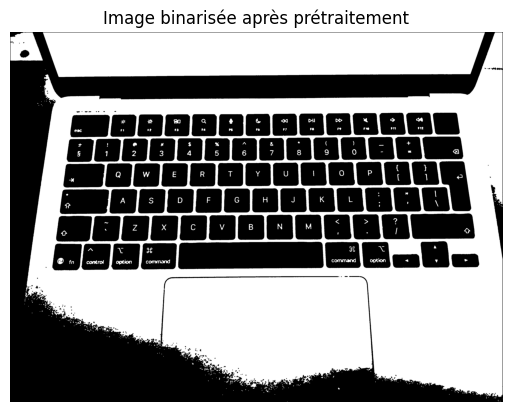

In [1]:
# Importer les dépendances
import os, sys
import matplotlib.pyplot as plt
from skimage import io

# Ajouter le répertoire parent au chemin Python pour que 'src' puisse être trouvé
sys.path.append(os.path.abspath('..'))

# Importer la fonction de prétraitement depuis preprocessing.py
from src.preprocessing import pretraiter_image

# Charger l’image d’entrée et appliquer le prétraitement pour obtenir une image binaire
chemin_image = '../data/img/INT-qwerty-1.jpg'
binaire = pretraiter_image(io.imread(chemin_image))

# Afficher l’image binaire résultante en niveaux de gris
plt.imshow(binaire, cmap='gray')
plt.title('Image binarisée après prétraitement')
plt.axis('off')
plt.show()

>À ce stade : on obtient une image “noir et blanc” où chaque touche est une forme isolée.

---

## **2. Détection des touches individuelles**

**Objectif :** repérer les touches et extraire leur géométrie.

- **Contours** : appliquer un algorithme de recherche de composantes connexes ou de contours (implémenté à la main si besoin).
- **Filtrage des régions** :

    - Supprimer les très petites ou très grandes (bruit, bords du clavier).
    - Garder les rectangles approximatifs.
- **Approximation rectangulaire** : calculer le rectangle englobant chaque touche.
- **Visualisation** : afficher les bounding boxes pour vérification.

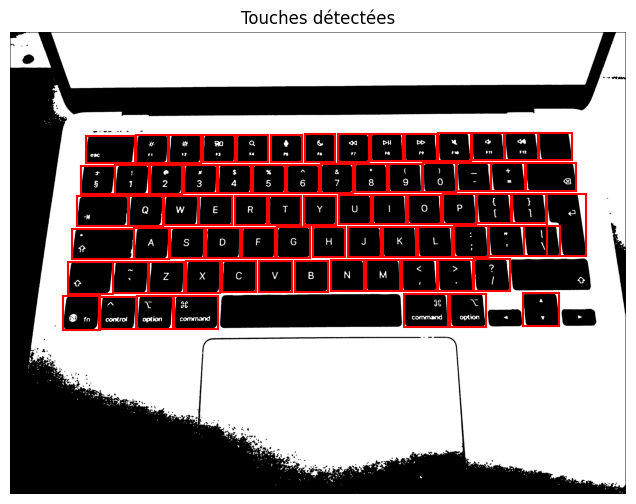

In [2]:
from src.key_detection import detecter_touches

boites_touches = detecter_touches(binaire)

plt.figure(figsize=(10, 6))
plt.imshow(binaire, cmap='gray')
for bbox in boites_touches:
    minr, minc, maxr, maxc = bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                         edgecolor='red', facecolor='none', linewidth=1.5)
    plt.gca().add_patch(rect)
plt.axis('off')
plt.title("Touches détectées")
plt.show()

---

## **3. Reconstruction de la grille**

**Objectif :** organiser les touches en lignes et colonnes.

- Trier les touches selon leur coordonnée `y` pour regrouper par ligne.
- Calculer la moyenne de `y` dans chaque groupe → lignes du clavier.
- Trier ensuite dans chaque ligne par coordonnée `x`.
- Représenter la structure comme une matrice de symboles (touches).


Ligne 0 : 14 touches
  [0] bbox=(677, 494, 860, 816), dim=(322x183)
  [1] bbox=(675, 822, 857, 1034), dim=(212x182)
  [2] bbox=(674, 1042, 854, 1252), dim=(210x180)
  [3] bbox=(673, 1264, 853, 1472), dim=(208x180)
  [4] bbox=(672, 1486, 852, 1691), dim=(205x180)
  [5] bbox=(671, 1707, 851, 1909), dim=(202x180)
  [6] bbox=(669, 1928, 850, 2129), dim=(201x181)
  [7] bbox=(668, 2146, 849, 2349), dim=(203x181)
  [8] bbox=(666, 2365, 846, 2570), dim=(205x180)
  [9] bbox=(664, 2583, 844, 2792), dim=(209x180)
  [10] bbox=(663, 2803, 842, 3014), dim=(211x179)
  [11] bbox=(660, 3022, 840, 3236), dim=(214x180)
  [12] bbox=(659, 3241, 839, 3457), dim=(216x180)
  [13] bbox=(660, 3459, 838, 3678), dim=(219x178)
Ligne 1 : 14 touches
  [0] bbox=(874, 464, 1063, 686), dim=(222x189)
  [1] bbox=(872, 688, 1060, 907), dim=(219x188)
  [2] bbox=(871, 914, 1057, 1128), dim=(214x186)
  [3] bbox=(870, 1138, 1055, 1352), dim=(214x185)
  [4] bbox=(869, 1364, 1054, 1575), dim=(211x185)
  [5] bbox=(869, 1590, 105

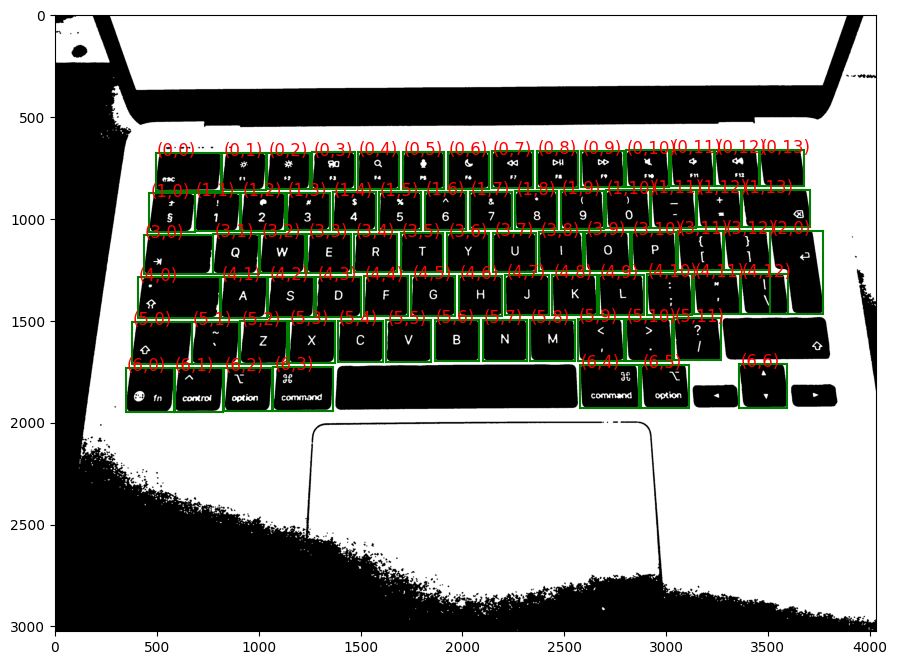

In [6]:
from src.construct_grid import reconstruire_grille, afficher_grille

# Reconstruire la grille à partir des boites de touches détectées
grille = reconstruire_grille(boites_touches, seuil_y=50)

# Afficher des informations sur la grille
afficher_grille(grille)

# Visualiser : afficher la grille sur l'image
plt.figure(figsize=(12, 8))
plt.imshow(binaire, cmap='gray')

for num_ligne, ligne in enumerate(grille):
    for num_col, touche in enumerate(ligne):
        minr, minc, maxr, maxc = touche["bbox"]
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                             edgecolor='green', facecolor='none', linewidth=1.5)
        plt.gca().add_patch(rect)
        # Ajouter le numéro de la touche
        plt.text(minc + 5, minr + 15, f"({num_ligne},{num_col})", 
                color='red', fontsize=12)

print(f"Grille : {len(grille)} lignes")
for i, ligne in enumerate(grille):
    print(f"  Ligne {i} : {len(ligne)} touches")